In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

## Read Data

In [2]:
df  = pd.read_csv('../Dataset/brazilian_ecommerce_cleaned.csv')
y = df["is_delayed"]
X = df.drop(["is_delayed"], axis=1, inplace=False)

In [3]:
ohe_features = ["payment_type"]
te_features = ["order_status", "product_category_name", "customer_city", "customer_state", "seller_city", "seller_state", "daypart"]
transformer = make_column_transformer((OneHotEncoder(), ohe_features),
                                   (TargetEncoder(), te_features))
X_ec = transformer.fit_transform(X, y)

In [4]:
ohe_feature_names = transformer.named_transformers_["onehotencoder"].get_feature_names()
te_feature_names = transformer.named_transformers_["targetencoder"].get_feature_names()
enc_feature_names = list(ohe_feature_names) + list(te_feature_names)

df_enc = pd.DataFrame(data = X_ec,columns = enc_feature_names)

X.drop(ohe_features + te_features, axis = 1, inplace = True)
X = pd.concat([X, df_enc], axis = 1)

In [5]:
# X_dev, X_test, y_dev, y_test = train_test_split(X, y, stratify=y, train_size=0.8, shuffle=True, random_state=19)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=19)

In [6]:
print("Number of development data:", len(X_dev))
print("Distribution of development data:")
print(y_dev.value_counts())

Number of development data: 92506
Distribution of development data:
False    85553
True      6953
Name: is_delayed, dtype: int64


In [7]:
print("Number of test data:", len(X_test))
print("Distribution of test data:")
print(y_test.value_counts())

Number of test data: 23127
Distribution of test data:
False    21364
True      1763
Name: is_delayed, dtype: int64


## Random Forest Parameters

In [8]:
ne = 50
md = 10
rs = 19

## Stratified sampling

In [9]:
rf_ss = RandomForestClassifier(n_estimators=ne, max_depth=md, random_state=rs).fit(X_dev, y_dev)
y_pred_prob_ss = rf_ss.predict_proba(X_test)

In [10]:
rf_ss.classes_

array([False,  True])

## Undersampling

In [11]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(replacement=False, random_state=19)
X_dev_us, y_dev_us = rus.fit_resample(X_dev, y_dev)

In [12]:
y_dev_us.value_counts()

True     6953
False    6953
Name: is_delayed, dtype: int64

In [13]:
rf_us = RandomForestClassifier(n_estimators=ne, max_depth=md, random_state=rs).fit(X_dev_us, y_dev_us)
y_pred_prob_us = rf_us.predict_proba(X_test)

In [14]:
rf_us.classes_

array([False,  True])

## SMOTE sampling

In [15]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=19)
X_dev_smote, y_dev_smote = smote.fit_resample(X_dev, y_dev)

In [16]:
y_dev_smote.value_counts()

True     85553
False    85553
Name: is_delayed, dtype: int64

In [17]:
rf_smote = RandomForestClassifier(n_estimators=ne, max_depth=md, random_state=rs).fit(X_dev_smote, y_dev_smote)
y_pred_prob_smote = rf_smote.predict_proba(X_test)

In [18]:
rf_smote.classes_

array([False,  True])

## Ensemble resampling

In [19]:
rf_es = BalancedRandomForestClassifier(n_estimators=ne, max_depth=md, random_state=rs).fit(X_dev, y_dev)
y_pred_prob_es = rf_es.predict_proba(X_test)

In [20]:
rf_es.classes_

array([False,  True])

## Plotting

### Precision Recall Curve

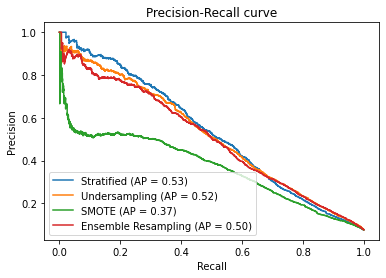

In [21]:
from sklearn.metrics import roc_curve, plot_precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
from matplotlib import pyplot as plt

plot_precision_recall_curve(rf_ss,  X_test, y_test, ax = plt.gca(),name = "Stratified")
plot_precision_recall_curve(rf_us, X_test, y_test, ax = plt.gca(),name = "Undersampling")
plot_precision_recall_curve(rf_smote, X_test, y_test, ax = plt.gca(),name = "SMOTE")
plot_precision_recall_curve(rf_es,  X_test, y_test, ax = plt.gca(),name = "Ensemble Resampling")

plt.title('Precision-Recall curve')
plt.rcParams["figure.figsize"] = (12, 5)
plt.show()

### ROC Curve

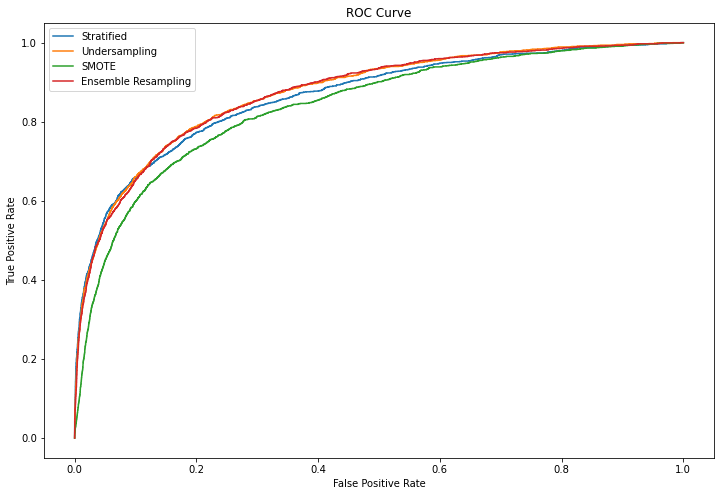

In [22]:
fpr_ss, tpr_ss, thresholds_ss = roc_curve(y_test, y_pred_prob_ss[:, 1], pos_label = 1)
fpr_us, tpr_us, thresholds_us = roc_curve(y_test, y_pred_prob_us[:, 1], pos_label = 1)
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, y_pred_prob_smote[:, 1], pos_label = 1)
fpr_es, tpr_es, thresholds_es = roc_curve(y_test, y_pred_prob_es[:, 1], pos_label = 1)

plt.figure(figsize = (12, 8))
plt.plot(fpr_ss, tpr_ss, label = "Stratified")
plt.plot(fpr_us, tpr_us, label = "Undersampling")
plt.plot(fpr_smote, tpr_smote, label = "SMOTE")
plt.plot(fpr_es, tpr_es, label = "Ensemble Resampling")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()